In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from IPython.display import clear_output

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

class PlotLearning(keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

In [2]:
df = pd.read_csv('../data/LSTM.csv')
df['DATE'] = pd.to_datetime(df.DATE, format='%d/%m/%Y')

scaler = MinMaxScaler(feature_range=(0, 1))
df.iloc[:, 2:] = scaler.fit_transform(df.iloc[:, 2:])
df.iloc[:, 1:2] = y = scaler.fit_transform(df.iloc[:, 1:2])

train_df = df[(df['DATE'] < '2000')]
test_df = df[('2000' <= df['DATE']) & (df['DATE'] < '2017')]

In [17]:
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences.iloc[i:end_ix, 1:], sequences.iloc[end_ix-1:out_end_ix, 0]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# choose a number of time steps #change this accordingly
n_features = 7
n_steps_in, n_steps_out= 24 , 1

# covert into input/output
train_X , train_y = split_sequences(train_df.iloc[:, 1:], n_steps_in, n_steps_out)
test_X , test_y = split_sequences(test_df.iloc[:, 1:], n_steps_in, n_steps_out)

In [21]:
#optimizer learning rate
opt = keras.optimizers.Adam(learning_rate=0.0001)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units=50))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(units=1))
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['mse'])

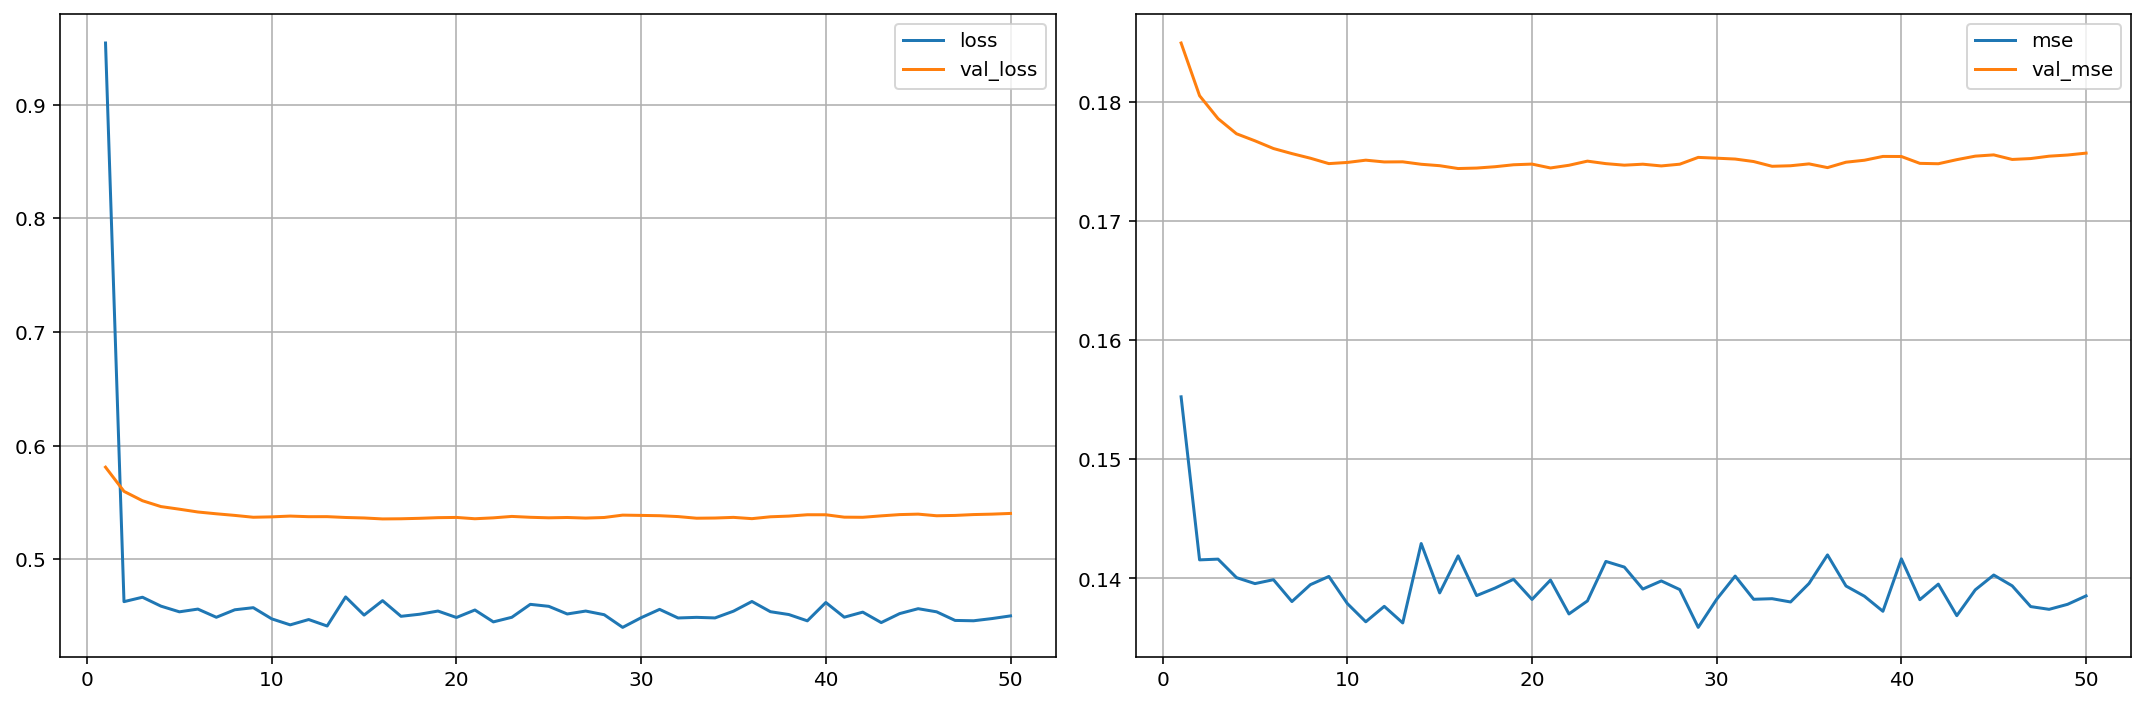

In [22]:
history = model.fit(train_X, train_y,
                    steps_per_epoch=25,
                    epochs=50,
                    verbose=0, 
                    validation_data=(test_X, test_y),
                    callbacks=[PlotLearning()],
                    shuffle=False)

In [27]:
print(np.where(model.predict(test_X) > 0.15)[0])
print(np.where(test_y > 0.5)[0])

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 67 68 69 70 71 72 73]
[  1   2   3   4   5   6   7   8   9  10  71  72  73  74  75  76  78  79
  80  81  82  83  84  85  86  87 101 102 103 104 114 115 116 117 118 162
 163 164 165 166]
